In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import Pool, cv,CatBoostRegressor

In [30]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [31]:
data = train_df[train_df['label'] == 1].drop(['label'], axis=1).dropna()

In [32]:
data.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare', 'pickup_date', 'pickup_hour',
       'pickup_minute', 'drop_date', 'drop_hour', 'drop_minute',
       'pick_cluster', 'is_more_than_one_day', 'distance_km', 'fare_per_km',
       'pickup_timeslot', 'day_of_week', 'is_weekday', 'cal_time_difference'],
      dtype='object')

In [33]:
cat_features = ['pick_cluster','is_more_than_one_day','pickup_timeslot',
       'day_of_week', 'is_weekday']

features = [
    'additional_fare',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'pick_cluster', 
    'is_more_than_one_day', 
    'distance_km',
    'pickup_timeslot',
    'day_of_week', 
    'is_weekday',
    'fare'
]

In [34]:
X = data[features]
y = data['duration'].values

In [35]:
train_df_X = train_df[features]
train_df_pool = Pool(data=train_df_X,cat_features=cat_features)
test_df_X = test_df[features]
test_df_pool = Pool(data=test_df_X,cat_features=cat_features)

In [36]:
train_df_preds = np.zeros(train_df.shape[0])
test_df_preds = np.zeros(test_df.shape[0])

In [37]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

In [38]:
kf = KFold(n_splits=3)

In [39]:
validation_scores = []
models = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostRegressor(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    validation_score = model.best_score_['validation']['RMSE']
    print('Validation RMSE',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    
    train_df_preds += model.predict(train_df_pool)
    test_df_preds += model.predict(test_df_pool)

Learning rate set to 0.071592
0:	learn: 4685.6250691	test: 2617.5072523	best: 2617.5072523 (0)	total: 6.04ms	remaining: 6.03s
10:	learn: 3912.7100782	test: 2457.0053470	best: 2457.0053470 (10)	total: 51.5ms	remaining: 4.63s
20:	learn: 3291.5470347	test: 2354.5605560	best: 2354.5605560 (20)	total: 94.4ms	remaining: 4.4s
30:	learn: 2782.7850949	test: 2283.3478767	best: 2283.3478767 (30)	total: 142ms	remaining: 4.43s
40:	learn: 2349.7534625	test: 2206.4686897	best: 2206.4686897 (40)	total: 189ms	remaining: 4.42s
50:	learn: 1968.8924777	test: 2087.9525310	best: 2087.9525310 (50)	total: 244ms	remaining: 4.54s
60:	learn: 1650.6664119	test: 2015.2169181	best: 2015.2169181 (60)	total: 302ms	remaining: 4.64s
70:	learn: 1392.0862050	test: 1952.8712860	best: 1952.8712860 (70)	total: 354ms	remaining: 4.63s
80:	learn: 1178.2677539	test: 1906.2823969	best: 1906.2823969 (80)	total: 405ms	remaining: 4.59s
90:	learn: 1006.0940939	test: 1874.6178622	best: 1874.6178622 (90)	total: 457ms	remaining: 4.56s


140:	learn: 338.4037510	test: 5863.8988550	best: 5863.8988550 (140)	total: 675ms	remaining: 4.11s
150:	learn: 324.7685761	test: 5856.4965732	best: 5856.4965732 (150)	total: 719ms	remaining: 4.04s
160:	learn: 314.6785401	test: 5849.1167353	best: 5849.1167353 (160)	total: 764ms	remaining: 3.98s
170:	learn: 306.1830221	test: 5845.7322303	best: 5845.6637716 (169)	total: 809ms	remaining: 3.92s
180:	learn: 301.0304914	test: 5844.7923648	best: 5844.7733074 (179)	total: 855ms	remaining: 3.87s
190:	learn: 296.0488209	test: 5842.5858591	best: 5842.4995978 (189)	total: 908ms	remaining: 3.85s
200:	learn: 291.3024817	test: 5840.7472140	best: 5840.7472140 (200)	total: 953ms	remaining: 3.79s
210:	learn: 287.0945005	test: 5839.6881337	best: 5839.6881337 (210)	total: 995ms	remaining: 3.72s
220:	learn: 284.3408428	test: 5839.2023276	best: 5839.2023276 (220)	total: 1.03s	remaining: 3.65s
230:	learn: 282.3407501	test: 5838.7225617	best: 5838.7225617 (230)	total: 1.08s	remaining: 3.58s
240:	learn: 280.2603

In [40]:
np.mean(validation_scores), np.std(validation_scores)

(2981.492623991606, 2017.0252135091896)

In [41]:
best_model = models[np.argmax(validation_scores)]

In [42]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,meter_waiting_fare,22.507397
1,is_more_than_one_day,21.421317
2,fare,19.669048
3,distance_km,14.062729
4,meter_waiting,10.652732
5,meter_waiting_till_pickup,4.801282
6,pick_cluster,3.961935
7,additional_fare,2.553974
8,day_of_week,0.155425
9,pickup_timeslot,0.114672


In [43]:
train_df['predicted_duration'] = train_df_preds/3
test_df['predicted_duration'] = test_df_preds/3

In [44]:
train_df['predicted_duration_difference'] = train_df['duration'] - train_df['predicted_duration']
test_df['predicted_duration_difference'] = test_df['duration'] - test_df['predicted_duration']

In [45]:
train_df['predicted_duration_difference_per_duration'] = train_df['predicted_duration_difference'] / (train_df['duration'] + 1)
test_df['predicted_duration_difference_per_duration'] = test_df['predicted_duration_difference'] / (test_df['duration'] + 1)

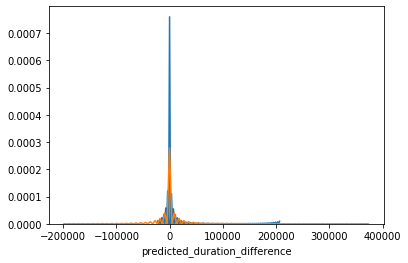

In [46]:
sns.distplot(train_df[train_df['label']==1]['predicted_duration_difference'], hist=False)
sns.distplot(train_df[train_df['label']==0]['predicted_duration_difference'], hist=False)

In [47]:
train_df.to_csv('train_df_reg_duration.csv',index=False)
test_df.to_csv('test_df_reg_duration.csv',index=False)